In [1]:
import torch
from torch import nn
from pathlib import Path
import random
import os
from PIL import Image
from utils import print_dir, loss_curves
import torchvision


IMG_PATH = Path('../data/cats/')
TRAIN_DIR = IMG_PATH / "train"
TEST_DIR = IMG_PATH / "test"


SEED = 1809
EPOCHS = 5

random.seed(SEED)

torch.__version__

c:\Users\ruair\Documents\Code\cat_classifier\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.1+cu117'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Explopre the directory

In [3]:
print_dir(IMG_PATH)

There are 2 directories and 0 images in '..\data\cats'.
There are 2 directories and 0 images in '..\data\cats\test'.
There are 0 directories and 19 images in '..\data\cats\test\magnus'.
There are 0 directories and 11 images in '..\data\cats\test\winnie'.
There are 2 directories and 0 images in '..\data\cats\train'.
There are 0 directories and 172 images in '..\data\cats\train\magnus'.
There are 0 directories and 101 images in '..\data\cats\train\winnie'.


In [4]:
image_path_list = list(IMG_PATH.glob("*/*/*.jpg")) +  list(IMG_PATH.glob("*/*/*.JPEG"))

Random image path: ..\data\cats\train\magnus\IMG_6295.JPEG
Image class: magnus
Image height: 2048
Image width: 1536


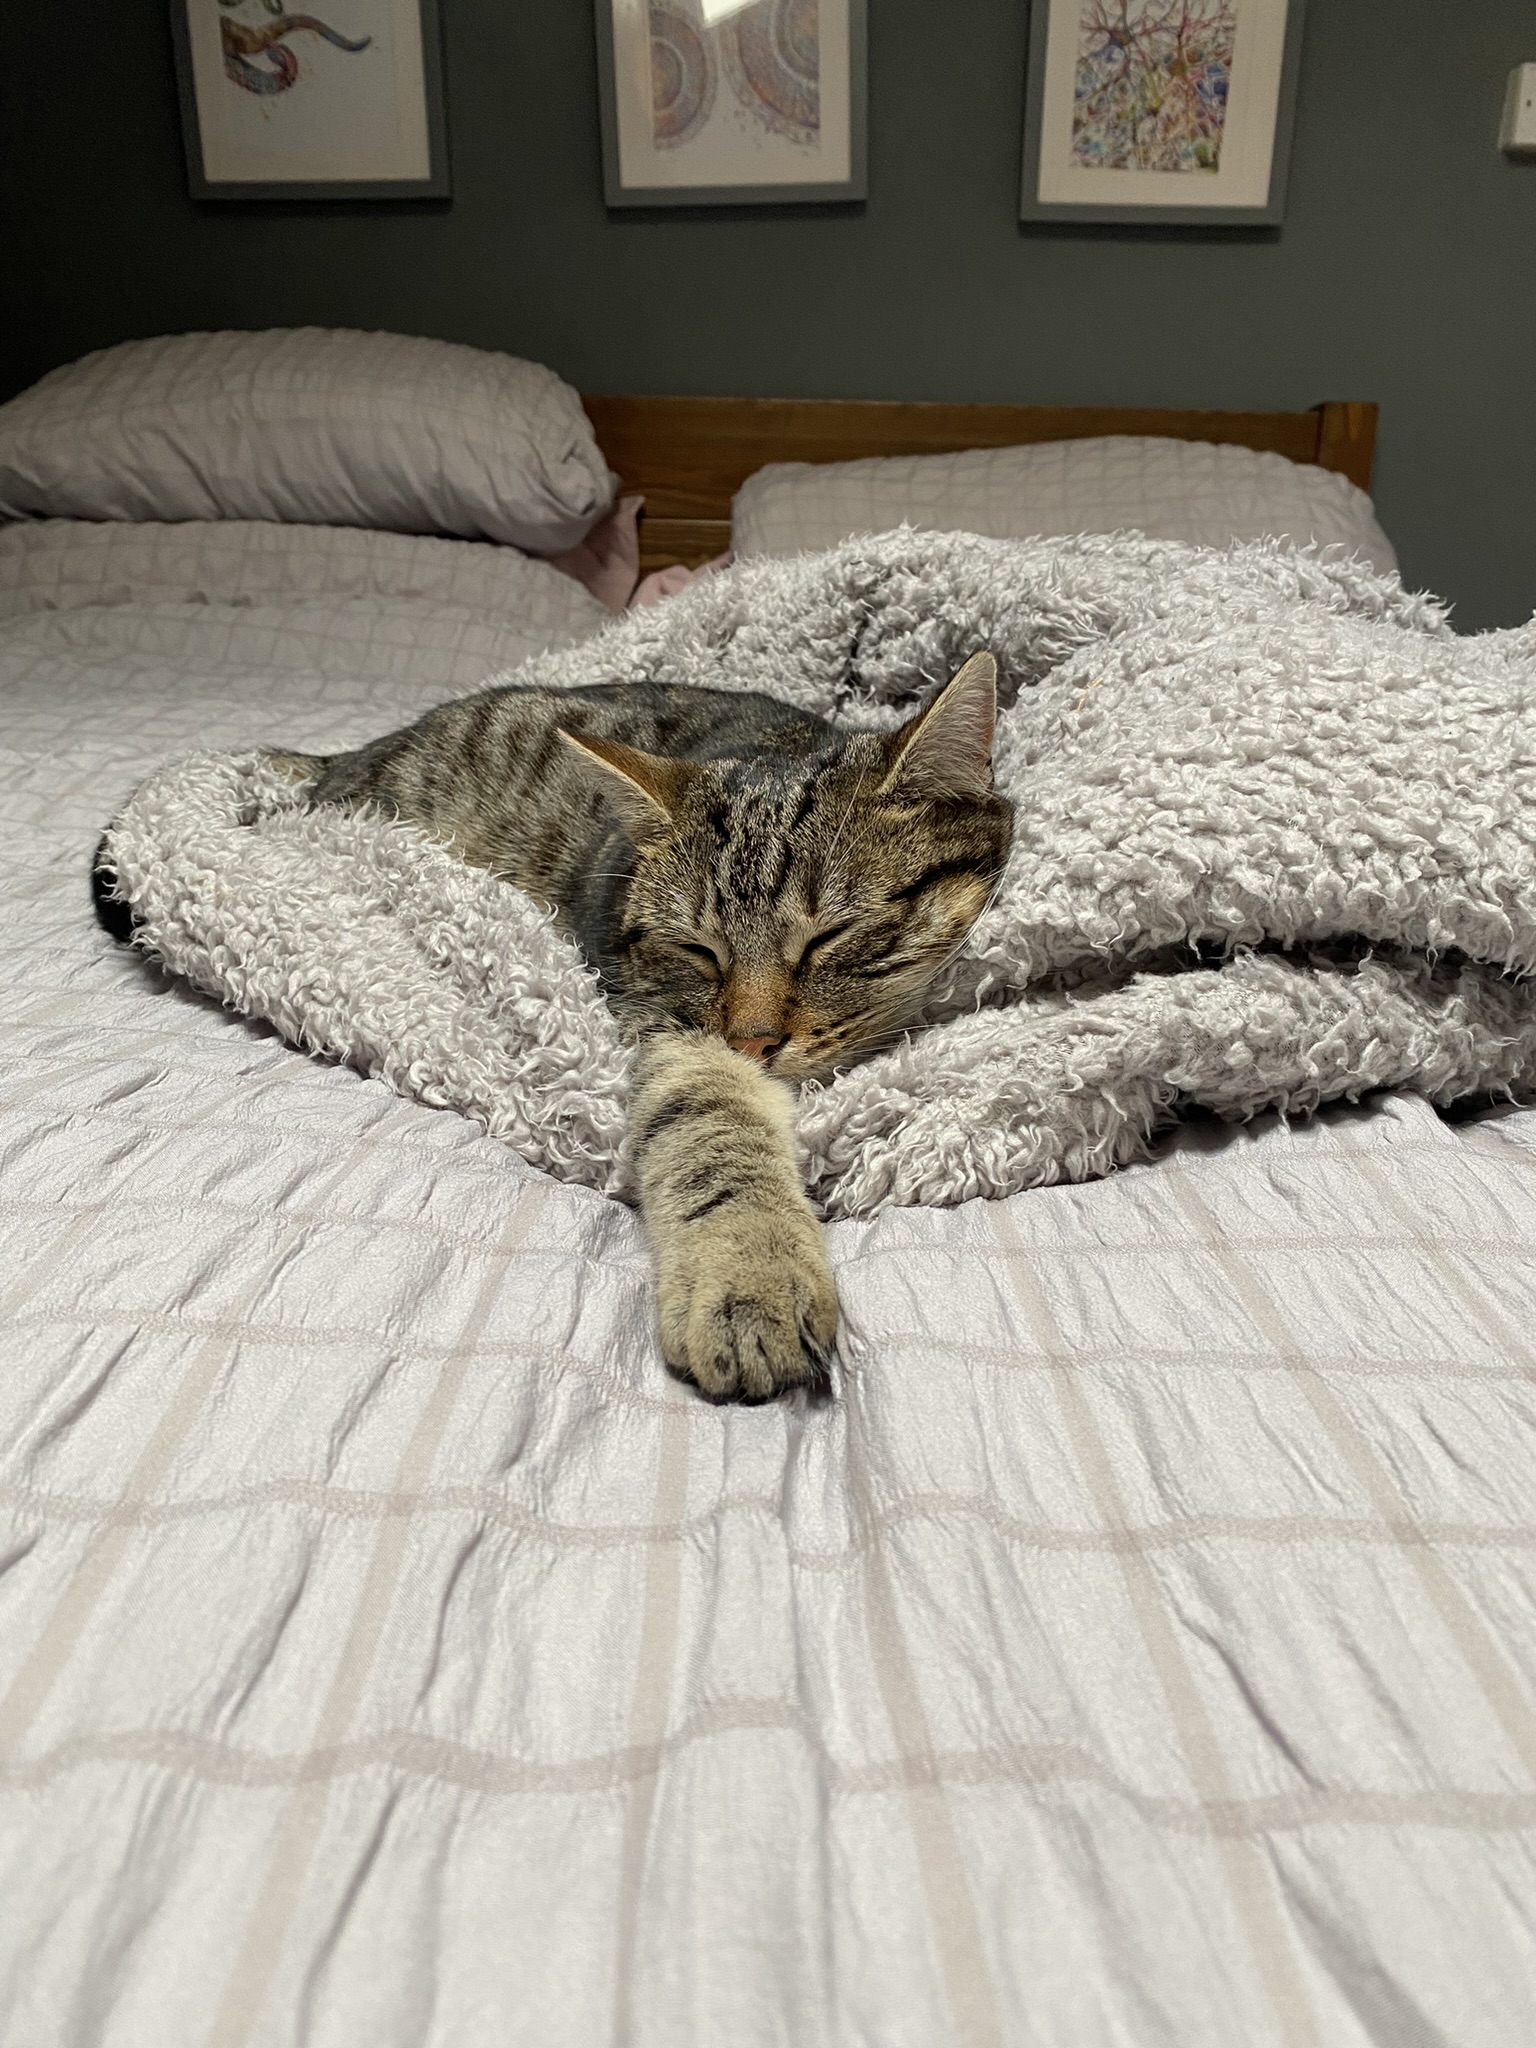

In [5]:
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: { random_image_path.parent.stem}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Transformation of the data

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [7]:
SIZE = 128

train_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

test_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)), 
    transforms.ToTensor()
])


In [8]:
train_data = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=train_transforms, 
                                  target_transform=None)

test_data = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 273
    Root location: ..\data\cats\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 30
    Root location: ..\data\cats\test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


Inspect a single example

In [9]:
train_data.class_to_idx

{'magnus': 0, 'winnie': 1}

In [10]:
print(train_data[0][0].shape)
print('label: ', train_data[0][1])


torch.Size([3, 128, 128])
label:  0


Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


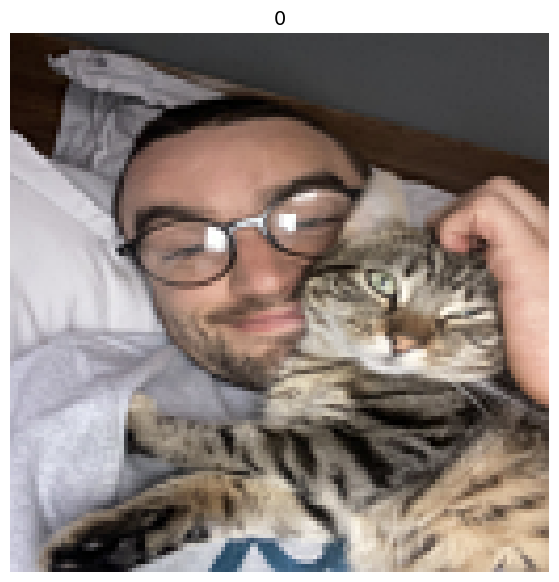

In [11]:
ind =  70
img, label = train_data[ind][0], train_data[ind][1]
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(label, fontsize=14)
plt.show()

Create a data loader 

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=NUM_WORKERS, shuffle=False)

Base model

In [13]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


In [14]:
class TinyVGG(nn.Module):
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x



In [15]:
vgg = TinyVGG(input_shape=3, hidden_units=10, 
                  output_shape=1).to(device)

In [16]:
vgg

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=1, bias=True)
  )
)

In [17]:


img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

vgg.eval()
with torch.inference_mode():
    pred = vgg(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")



Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[-0.0346]], device='cuda:0')

Output prediction probabilities:
tensor([[1.]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
1


Model inspection

In [18]:
   
from torchinfo import summary
summary(vgg, input_size=[1, 3, SIZE, SIZE])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 10, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 10, 128, 128]         280
│    └─ReLU: 2-2                         [1, 10, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 10, 128, 128]         910
│    └─ReLU: 2-4                         [1, 10, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 10, 64, 64]           --
├─Sequential: 1-2                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 10, 64, 64]           910
│    └─ReLU: 2-7                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 10, 64, 64]           910
│    └─ReLU: 2-9                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-10                   [1, 10, 32, 32]           --
├─Sequentia

training function

In [19]:
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
       
        y_pred = model(X).float()
        y = y.unsqueeze(1).float()

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.round(torch.sigmoid(y_pred))
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X).float()

            y = y.unsqueeze(1).float()
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_class = torch.round(torch.sigmoid(y_pred))
            test_acc += ((y_pred_class == y).sum().item()/len(y_pred))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

VGG = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=1).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(params=VGG.parameters(), lr=0.001)
model_0_results = train(model=VGG, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=EPOCHS)

 20%|██        | 1/5 [00:09<00:39,  9.84s/it]

Epoch: 1 | train_loss: 0.6719 | train_acc: 0.6217 | test_loss: 0.6573 | test_acc: 0.6333


 40%|████      | 2/5 [00:19<00:29,  9.91s/it]

Epoch: 2 | train_loss: 0.6844 | train_acc: 0.6340 | test_loss: 0.6650 | test_acc: 0.6333


 60%|██████    | 3/5 [00:29<00:19,  9.89s/it]

Epoch: 3 | train_loss: 0.6642 | train_acc: 0.6340 | test_loss: 0.6566 | test_acc: 0.6333


 80%|████████  | 4/5 [00:39<00:09,  9.83s/it]

Epoch: 4 | train_loss: 0.6678 | train_acc: 0.6187 | test_loss: 0.6562 | test_acc: 0.6333


100%|██████████| 5/5 [00:49<00:00,  9.88s/it]

Epoch: 5 | train_loss: 0.6592 | train_acc: 0.6309 | test_loss: 0.6560 | test_acc: 0.6333


Try a better model e.g. efficient net


In [20]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
auto_transforms = weights.transforms()
auto_transforms # get the neccesary transforms
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [21]:
train_data = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=auto_transforms, 
                                  target_transform=None)

test_data = datasets.ImageFolder(root=TEST_DIR, transform=auto_transforms)

class_names = train_data.classes

train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=NUM_WORKERS, shuffle=False)

In [22]:
# will need to freeze the feature extraction
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1,
                    bias=True)).to(device)

In [24]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
results  = train(model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=20)

  5%|▌         | 1/20 [00:11<03:29, 11.02s/it]

Epoch: 1 | train_loss: 0.6789 | train_acc: 0.5858 | test_loss: 0.6361 | test_acc: 0.6333


 10%|█         | 2/20 [00:21<03:13, 10.77s/it]

Epoch: 2 | train_loss: 0.5862 | train_acc: 0.7026 | test_loss: 0.5403 | test_acc: 0.7333


 15%|█▌        | 3/20 [00:32<03:01, 10.68s/it]

Epoch: 3 | train_loss: 0.5055 | train_acc: 0.7990 | test_loss: 0.4885 | test_acc: 0.8000


 20%|██        | 4/20 [00:42<02:51, 10.69s/it]

Epoch: 4 | train_loss: 0.4585 | train_acc: 0.8388 | test_loss: 0.4606 | test_acc: 0.7667


 25%|██▌       | 5/20 [00:53<02:39, 10.61s/it]

Epoch: 5 | train_loss: 0.4302 | train_acc: 0.8523 | test_loss: 0.4222 | test_acc: 0.8667


 30%|███       | 6/20 [01:04<02:31, 10.80s/it]

Epoch: 6 | train_loss: 0.3807 | train_acc: 0.9071 | test_loss: 0.3950 | test_acc: 0.8667


 35%|███▌      | 7/20 [01:15<02:19, 10.75s/it]

Epoch: 7 | train_loss: 0.3665 | train_acc: 0.9171 | test_loss: 0.3727 | test_acc: 0.9000


 40%|████      | 8/20 [01:25<02:07, 10.63s/it]

Epoch: 8 | train_loss: 0.3284 | train_acc: 0.9379 | test_loss: 0.3609 | test_acc: 0.8667


 45%|████▌     | 9/20 [01:35<01:56, 10.56s/it]

Epoch: 9 | train_loss: 0.3062 | train_acc: 0.9318 | test_loss: 0.3522 | test_acc: 0.8667


 50%|█████     | 10/20 [01:46<01:45, 10.54s/it]

Epoch: 10 | train_loss: 0.3124 | train_acc: 0.9179 | test_loss: 0.3342 | test_acc: 0.8667


 55%|█████▌    | 11/20 [01:56<01:34, 10.49s/it]

Epoch: 11 | train_loss: 0.2608 | train_acc: 0.9792 | test_loss: 0.3229 | test_acc: 0.9000


 60%|██████    | 12/20 [02:07<01:24, 10.54s/it]

Epoch: 12 | train_loss: 0.2568 | train_acc: 0.9688 | test_loss: 0.3197 | test_acc: 0.9000


 65%|██████▌   | 13/20 [02:18<01:14, 10.67s/it]

Epoch: 13 | train_loss: 0.2521 | train_acc: 0.9518 | test_loss: 0.3115 | test_acc: 0.9000


 70%|███████   | 14/20 [02:28<01:03, 10.62s/it]

Epoch: 14 | train_loss: 0.2559 | train_acc: 0.9326 | test_loss: 0.2988 | test_acc: 0.9000


 75%|███████▌  | 15/20 [02:39<00:52, 10.59s/it]

Epoch: 15 | train_loss: 0.2282 | train_acc: 0.9553 | test_loss: 0.3039 | test_acc: 0.8667


 80%|████████  | 16/20 [02:49<00:42, 10.54s/it]

Epoch: 16 | train_loss: 0.2318 | train_acc: 0.9457 | test_loss: 0.2940 | test_acc: 0.8667


 85%|████████▌ | 17/20 [03:00<00:31, 10.52s/it]

Epoch: 17 | train_loss: 0.2133 | train_acc: 0.9792 | test_loss: 0.2832 | test_acc: 0.9000


 90%|█████████ | 18/20 [03:11<00:21, 10.56s/it]

Epoch: 18 | train_loss: 0.2030 | train_acc: 0.9653 | test_loss: 0.2738 | test_acc: 0.9000


 95%|█████████▌| 19/20 [03:21<00:10, 10.57s/it]

Epoch: 19 | train_loss: 0.1977 | train_acc: 0.9761 | test_loss: 0.2679 | test_acc: 0.9000


100%|██████████| 20/20 [03:32<00:00, 10.62s/it]

Epoch: 20 | train_loss: 0.2067 | train_acc: 0.9565 | test_loss: 0.2775 | test_acc: 0.8667


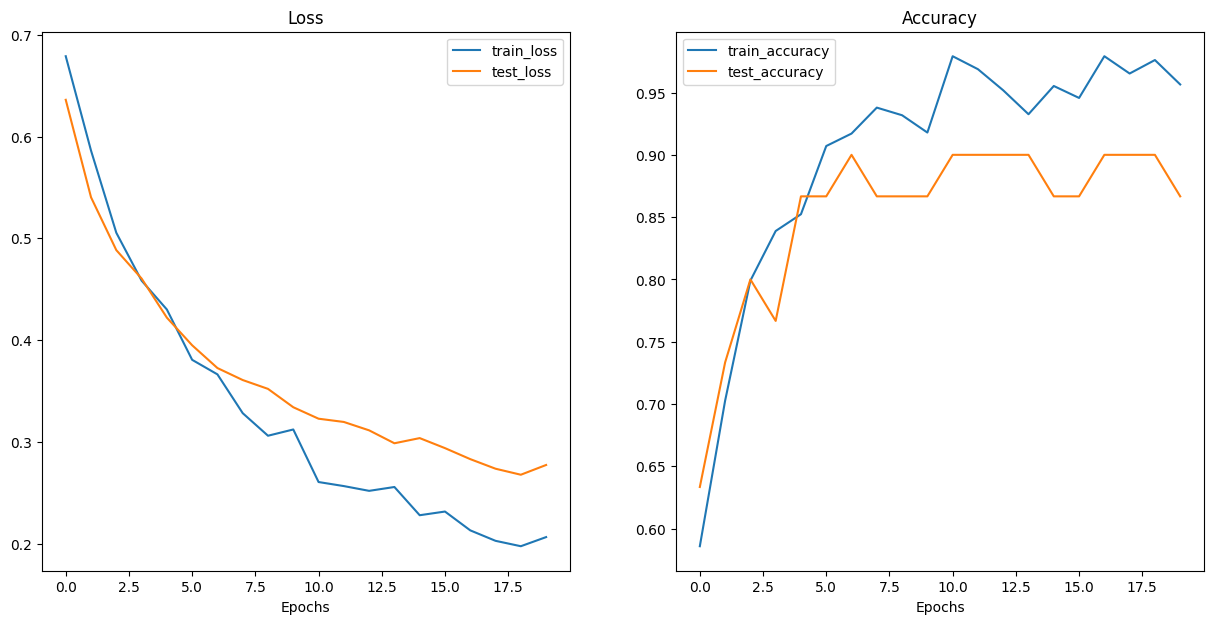

In [27]:
from utils import loss_curves
loss_curves(results)

Inspect the predictions

In [30]:
def plot_predictions(model, path, transforms, device, n_images = 5):
    test_image_path_list = list(Path(path).glob("*/*.j*")) # get list all image paths from test data 
    path = random.sample(test_image_path_list, k=n_images)

    for img in path:
        model.to(device)

        # 5. Turn on model evaluation mode and inference mode
        model.eval()
        with torch.inference_mode():
            img = Image.open(img)
            transformed_image = transforms(img).unsqueeze(dim=0)
            y_pred = model(transformed_image.to(device))
            y_pred_class =torch.sigmoid(y_pred)
            prob = y_pred_class[0][0].item()
            prob_class_0, prob_class_1 = round(1 - prob, 2), round(prob, 2)
            prob_class_0, prob_class_1

        plt.figure()
        plt.imshow(im g)
        plt.title(f"Probability of magnus: {prob_class_0} | Probability of winnie: {prob_class_1}")
        plt.axis(False);



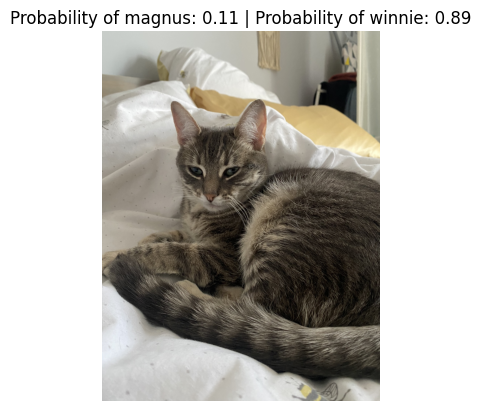

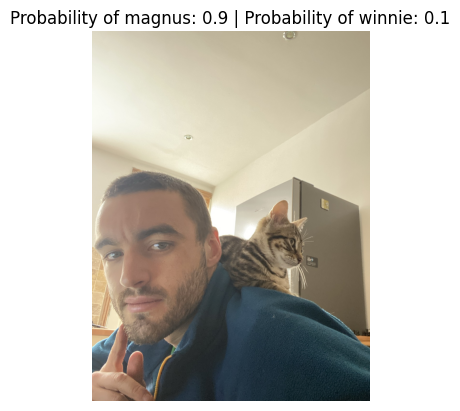

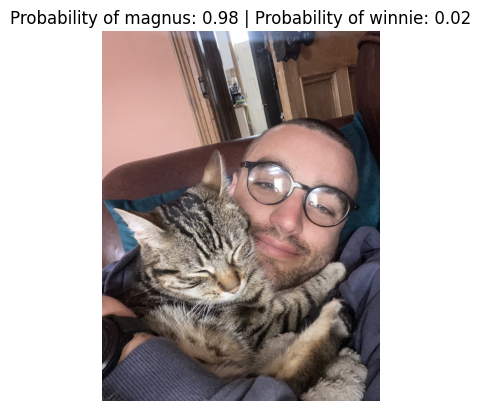

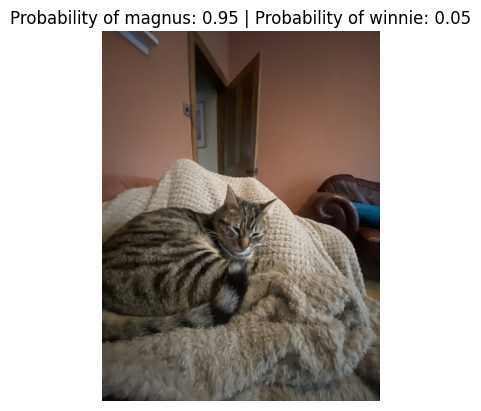

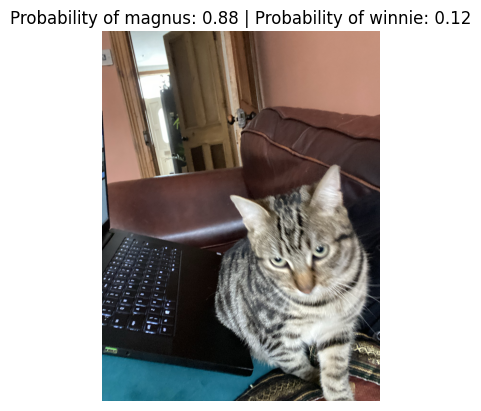

In [31]:
plot_predictions(model, TEST_DIR, auto_transforms, device)

Investigate the most wrong images

In [43]:
import pandas as pd
test_image_path_list = list(Path(TEST_DIR).glob("*/*.j*")) # get list all image paths from test data 
storage = []
for path in test_image_path_list:
    img = Image.open(path)
    transformed_image = auto_transforms(img).unsqueeze(dim=0)
    y_pred = model(transformed_image.to(device))
    y_pred_class =torch.sigmoid(y_pred)
    prob = y_pred_class[0][0].item()
    true_label = 0 if 'magnus' in str(path) else 1
    storage.append({'path' : path, 
     'true_label': true_label, 
     'pred_prob': prob, 
     'error': abs(true_label - prob)})

    


In [49]:
imgs = pd.DataFrame(storage).sort_values('error', ascending=False)
imgs.loc[imgs.error >= 0.5]

path  true_label  pred_prob  \
28             ..\data\cats\test\winnie\IMG_9020.JPEG           1   0.251358   
0   ..\data\cats\test\magnus\02B98FBD-0049-45E3-AE...           0   0.721419   
27             ..\data\cats\test\winnie\IMG_8952.JPEG           1   0.364534   
29             ..\data\cats\test\winnie\IMG_9603.JPEG           1   0.489571   

       error  
28  0.748642  
0   0.721419  
27  0.635466  
29  0.510429